In [1]:
from pypfopt import risk_models,expected_returns,EfficientFrontier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from src.config import load_config
import numpy as np
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices

class EfficientDiversification:
    def __init__(self,config):
        self.config = config
        self.all_prices = None #all assets combined
        self.mu = None # expected returns using pyportfolio
        self.S = None # Risk(Vol) through pyportfolio
        self.ef = None # Efficient Frontier using pyportfolio
        self.weights = None # weights
        self.performance = None # portfolio performance
        
    def load_data(self):
        """Loads in data from yfinance using config.yaml"""
        self.all_prices = yf.download(tickers=self.config['combined_assets'],start=self.config['start_date'],end=self.config['end_date'])['Close']
        self.all_prices = self.all_prices.dropna()
        return self.all_prices   
    
    def eval_returns(self):
        """
        The pct change for each asset(returns). This is not the same
        as 'Expected Returns'
        """

        returns = self.all_prices.pct_change().dropna()
        print(f'Returns: {returns}')
        return returns
    
    
    def portfolio_metrics(self):
        """
        args:
            (mu) -> Expected Returns (using pyportfolio)
            (S) -> Risk(Volatility);
            (Ef) -> Efficient Frontier;
        """

        if self.all_prices is None:
            self.load_data()
            if self.all_prices is None:
                return
            
        self.mu = expected_returns.mean_historical_return(self.all_prices)
        self.S = risk_models.sample_cov(self.all_prices)
        self.ef = EfficientFrontier(self.mu,self.S)
            

        self.weights = self.ef.max_sharpe()
        self.weights = self.ef.clean_weights()


            
        expected_annual_return, annual_volatility, sharpe_ratio = self.ef.portfolio_performance(verbose=True)
        self.performance = {
            "Expected Annual Return":expected_annual_return,
            "Annual Volatility":annual_volatility,
            "Sharpe Ratio":sharpe_ratio
        }
        return self.weights,self.performance



if __name__ == "__main__":
    config = load_config()
    ef_obj = EfficientDiversification(config)


In [2]:
data = ef_obj.load_data()
data

/tmp/ipykernel_24974/1896474652.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.all_prices = yf.download(tickers=self.config['combined_assets'],start=self.config['start_date'],end=self.config['end_date'])['Close']
[*********************100%***********************]  30 of 30 completed


Ticker,AAPL,ARKK,BNB-USD,BTC-USD,DIA,EFA,ETH-USD,F,GM,GOOGL,...,TRX-USD,TSLA,USDC-USD,USDT-USD,VOO,VTI,WMT,XLF,XLK,XRP-USD
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-23,127.606903,130.657455,31.097898,23241.345703,277.624725,63.043705,583.714600,6.900062,41.145016,85.896347,...,0.024820,215.326660,0.999939,0.999426,316.226990,180.402740,44.694592,26.696550,123.646606,0.258602
2020-12-24,128.591019,128.788986,32.500591,23735.949219,278.306519,63.069859,611.607178,6.800284,40.301762,86.191086,...,0.027697,220.589996,1.000074,0.999931,317.490753,180.704529,44.781971,26.733488,124.466347,0.337819
2020-12-28,133.190155,125.661949,35.844559,27084.808594,280.131073,63.584114,730.397339,6.823309,40.379299,88.169228,...,0.029532,221.229996,1.000101,0.998603,320.252258,181.847870,45.318726,26.862770,125.874397,0.247958
2020-12-29,131.416794,122.282272,38.952831,27362.437500,279.633575,63.993774,731.520142,6.769583,40.292076,87.364044,...,0.027690,221.996674,0.999978,0.998590,319.578278,181.088776,45.031631,26.770424,125.276436,0.220962
2020-12-30,130.296188,125.016708,38.136299,28840.953125,280.251038,64.080902,751.618958,6.800284,40.553768,86.294960,...,0.026945,231.593338,1.000011,1.000275,320.008881,181.576050,44.994179,26.890474,125.208977,0.211828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,227.160004,75.660004,840.171936,110124.351562,453.070007,92.000000,4372.987793,11.820000,58.279999,208.490005,...,0.342051,346.600006,0.999871,1.000123,590.700012,316.649994,96.070000,53.259998,261.829987,2.861272
2025-08-26,229.309998,76.269997,863.630493,111802.656250,454.489990,91.900002,4600.426758,11.840000,58.799999,207.139999,...,0.351972,351.670013,1.000019,1.000316,593.059998,318.089996,96.050003,53.669998,263.029999,3.012218
2025-08-27,230.490005,75.519997,855.646301,111222.062500,456.029999,91.680000,4503.393066,11.910000,58.750000,207.479996,...,0.345050,349.600006,0.999989,1.000059,594.419983,318.940002,96.080002,53.779999,264.450012,2.966618


In [3]:
returns = ef_obj.eval_returns()
returns

Returns: Ticker          AAPL      ARKK   BNB-USD   BTC-USD       DIA       EFA  \
Date                                                                     
2020-12-24  0.007712 -0.014301  0.045106  0.021281  0.002456  0.000415   
2020-12-28  0.035766 -0.024280  0.102889  0.141088  0.006556  0.008154   
2020-12-29 -0.013315 -0.026895  0.086715  0.010250 -0.001776  0.006443   
2020-12-30 -0.008527  0.022362 -0.020962  0.054034  0.002208  0.001362   
2020-12-31 -0.007702 -0.020535 -0.019935  0.005574  0.005458 -0.007617   
...              ...       ...       ...       ...       ...       ...   
2025-08-25 -0.002634 -0.011239 -0.065203 -0.057752 -0.007818 -0.013193   
2025-08-26  0.009465  0.008062  0.027921  0.015240  0.003134 -0.001087   
2025-08-27  0.005146 -0.009833 -0.009245 -0.005193  0.003388 -0.002394   
2025-08-28  0.008981  0.007283  0.021878  0.011893  0.001667  0.003709   
2025-08-29 -0.001806 -0.014592 -0.012683 -0.036732 -0.001532 -0.005868   

Ticker       ETH-USD        

Ticker,AAPL,ARKK,BNB-USD,BTC-USD,DIA,EFA,ETH-USD,F,GM,GOOGL,...,TRX-USD,TSLA,USDC-USD,USDT-USD,VOO,VTI,WMT,XLF,XLK,XRP-USD
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-24,0.007712,-0.014301,0.045106,0.021281,0.002456,0.000415,0.047785,-0.014460,-0.020495,0.003431,...,0.115915,0.024443,0.000135,0.000505,0.003996,0.001673,0.001955,0.001384,0.006630,0.306328
2020-12-28,0.035766,-0.024280,0.102889,0.141088,0.006556,0.008154,0.194226,0.003386,0.001924,0.022951,...,0.066253,0.002901,0.000027,-0.001328,0.008698,0.006327,0.011986,0.004836,0.011313,-0.266003
2020-12-29,-0.013315,-0.026895,0.086715,0.010250,-0.001776,0.006443,0.001537,-0.007874,-0.002160,-0.009132,...,-0.062373,0.003466,-0.000123,-0.000013,-0.002105,-0.004174,-0.006335,-0.003438,-0.004750,-0.108873
2020-12-30,-0.008527,0.022362,-0.020962,0.054034,0.002208,0.001362,0.027475,0.004535,0.006495,-0.012237,...,-0.026905,0.043229,0.000033,0.001687,0.001347,0.002691,-0.000832,0.004484,-0.000538,-0.041337
2020-12-31,-0.007702,-0.020535,-0.019935,0.005574,0.005458,-0.007617,-0.018381,-0.007901,-0.004780,0.009440,...,-0.004157,0.015674,-0.000204,0.000323,0.005382,0.004594,-0.000208,0.012363,0.001463,0.037851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,-0.002634,-0.011239,-0.065203,-0.057752,-0.007818,-0.013193,-0.094872,0.006814,-0.001542,0.011645,...,-0.066493,0.019382,0.000048,0.000409,-0.004231,-0.004809,-0.007849,-0.005787,-0.002248,-0.069739
2025-08-26,0.009465,0.008062,0.027921,0.015240,0.003134,-0.001087,0.052010,0.001692,0.008922,-0.006475,...,0.029004,0.014628,0.000148,0.000193,0.003995,0.004548,-0.000208,0.007698,0.004583,0.052755
2025-08-27,0.005146,-0.009833,-0.009245,-0.005193,0.003388,-0.002394,-0.021092,0.005912,-0.000850,0.001641,...,-0.019666,-0.005886,-0.000030,-0.000257,0.002293,0.002672,0.000312,0.002050,0.005399,-0.015138


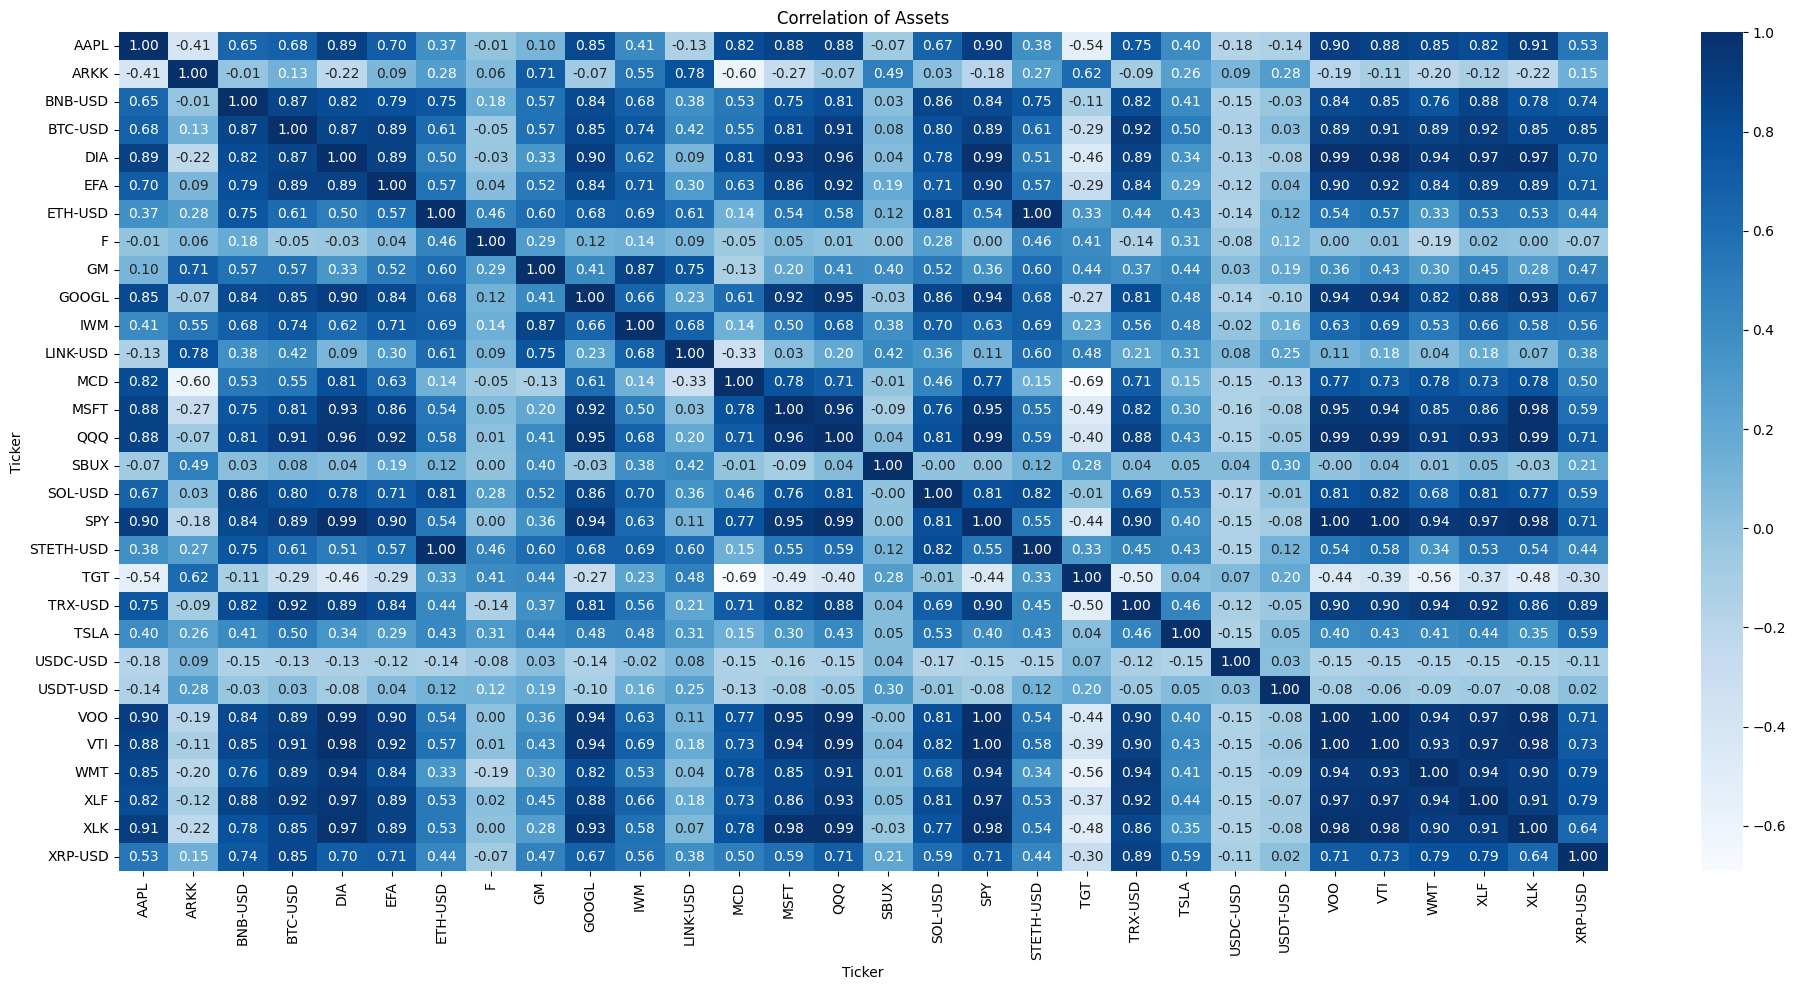

In [4]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),fmt=".2f",annot=True,cmap="Blues")
plt.title("Correlation of Assets")
plt.tight_layout()
plt.savefig("images/ef_assets_heatmap.png")
plt.show()

Value at Risk: -0.0411
Conditonal Value at Risk(CVaR): -0.0729


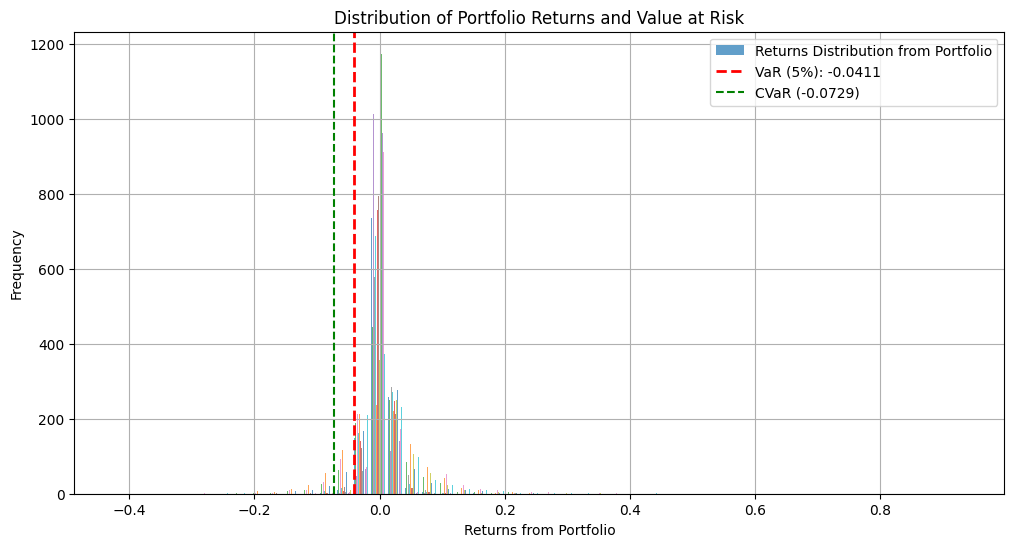

In [5]:
# VaR and Cvar for portfolio
var = np.percentile(returns,(1- 0.95)*100)
tail_risk = returns[returns < var]
cvar = np.mean(tail_risk)
print(f"Value at Risk: {var:.4f}")
print(f'Conditonal Value at Risk(CVaR): {cvar:.4f}')

plt.figure(figsize=(12,6))
plt.hist(returns,bins=50,label="Returns Distribution from Portfolio",alpha=0.7)
plt.axvline(var, color='r', linestyle='dashed', linewidth=2, label=f'VaR (5%): {var:.4f}')
plt.axvline(x=cvar, color='green', linestyle='--', label=f'CVaR ({cvar:.4f})')
plt.title('Distribution of Portfolio Returns and Value at Risk')
plt.xlabel('Returns from Portfolio')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig("images/VaR-Cvar-EfficientDiversification.png")
plt.show()


In [6]:
optimal_portfolio = ef_obj.portfolio_metrics()
optimal_portfolio

Expected annual return: 12.8%
Annual volatility: 6.6%
Sharpe Ratio: 1.94


(OrderedDict([('AAPL', 0.0),
              ('ARKK', 0.0),
              ('BNB-USD', 0.01574),
              ('BTC-USD', 0.0),
              ('DIA', 0.0),
              ('EFA', 0.0),
              ('ETH-USD', 0.0),
              ('F', 0.0),
              ('GM', 0.0),
              ('GOOGL', 0.0),
              ('IWM', 0.0),
              ('LINK-USD', 0.0),
              ('MCD', 0.05503),
              ('MSFT', 0.01058),
              ('QQQ', 0.0),
              ('SBUX', 0.0),
              ('SOL-USD', 0.04),
              ('SPY', 0.0),
              ('STETH-USD', 0.0),
              ('TGT', 0.0),
              ('TRX-USD', 0.00325),
              ('TSLA', 0.0),
              ('USDC-USD', 0.76176),
              ('USDT-USD', 0.0),
              ('VOO', 0.0),
              ('VTI', 0.0),
              ('WMT', 0.08998),
              ('XLF', 0.02367),
              ('XLK', 0.0),
              ('XRP-USD', 0.0)]),
 {'Expected Annual Return': np.float64(0.12761938055868258),
  'Annual Volatilit

In [7]:
weights = ef_obj.weights
weights

OrderedDict([('AAPL', 0.0),
             ('ARKK', 0.0),
             ('BNB-USD', 0.01574),
             ('BTC-USD', 0.0),
             ('DIA', 0.0),
             ('EFA', 0.0),
             ('ETH-USD', 0.0),
             ('F', 0.0),
             ('GM', 0.0),
             ('GOOGL', 0.0),
             ('IWM', 0.0),
             ('LINK-USD', 0.0),
             ('MCD', 0.05503),
             ('MSFT', 0.01058),
             ('QQQ', 0.0),
             ('SBUX', 0.0),
             ('SOL-USD', 0.04),
             ('SPY', 0.0),
             ('STETH-USD', 0.0),
             ('TGT', 0.0),
             ('TRX-USD', 0.00325),
             ('TSLA', 0.0),
             ('USDC-USD', 0.76176),
             ('USDT-USD', 0.0),
             ('VOO', 0.0),
             ('VTI', 0.0),
             ('WMT', 0.08998),
             ('XLF', 0.02367),
             ('XLK', 0.0),
             ('XRP-USD', 0.0)])

In [8]:
#greedy investor and discrete allocation

latest_prices = get_latest_prices(data)
# Discrete Allocation is using the optimized weights and your Willingness to Pay to show you how much you would recieve st W* and WTP
da = DiscreteAllocation(weights, latest_prices,total_portfolio_value=1000000)
print(f'Latest Prices: {latest_prices}')
allocation, leftover = da.greedy_portfolio()
print(f'Allocation to Assets if you have $1000000 USD: {allocation}')
print(f'Leftover Cash if you were to spend $1000000 USD on optimized Weights: {leftover}')

Latest Prices: Ticker
AAPL            232.139999
ARKK             74.959999
BNB-USD         863.276550
BTC-USD      108410.835938
DIA             456.089996
EFA              91.480003
ETH-USD        4360.152832
F                11.770000
GM               58.590000
GOOGL           212.910004
IWM             235.169998
LINK-USD         23.433657
MCD             313.540009
MSFT            506.690002
QQQ             570.400024
SBUX             88.190002
SOL-USD         205.220001
SPY             645.049988
STETH-USD      4351.366211
TGT              95.980003
TRX-USD           0.338837
TSLA            333.869995
USDC-USD          0.999914
USDT-USD          1.000146
VOO             593.080017
VTI             318.200012
WMT              96.980003
XLF              53.990002
XLK             262.450012
XRP-USD           2.821957
Name: 2025-08-29 00:00:00, dtype: float64
Allocation to Assets if you have $1000000 USD: {'USDC-USD': 761825, 'WMT': 927, 'MCD': 176, 'SOL-USD': 195, 'XLF': 439, 'BNB-U

In [9]:
mu = ef_obj.mu
volatility = ef_obj.S
sharpe_ratio = mu - 0.0092 / volatility
print(f'Expected Returns of Full Portfolio: {mu}')
print(f'volatility of full portfolio: {volatility}')
print(f'sharpe ratio of full portfolio: {sharpe_ratio}')

Expected Returns of Full Portfolio: Ticker
AAPL         0.136934
ARKK        -0.112338
BNB-USD      1.039705
BTC-USD      0.391357
DIA          0.112340
EFA          0.083119
ETH-USD      0.539201
F            0.121347
GM           0.078753
GOOGL        0.214921
IWM          0.048670
LINK-USD     0.179997
MCD          0.111710
MSFT         0.204891
QQQ          0.147904
SBUX        -0.008684
SOL-USD      2.009364
SPY          0.143573
STETH-USD    0.535756
TGT         -0.096629
TRX-USD      0.751708
TSLA         0.098631
USDC-USD    -0.000005
USDT-USD     0.000154
VOO          0.144391
VTI          0.129424
WMT          0.180736
XLF          0.163046
XLK          0.175173
XRP-USD      0.669554
dtype: float64
volatility of full portfolio: Ticker         AAPL      ARKK   BNB-USD   BTC-USD       DIA       EFA  \
Ticker                                                                  
AAPL       0.080248  0.078717  0.045872  0.042982  0.027673  0.026619   
ARKK       0.078717  0.227446  0.

/tmp/ipykernel_24974/2285642073.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


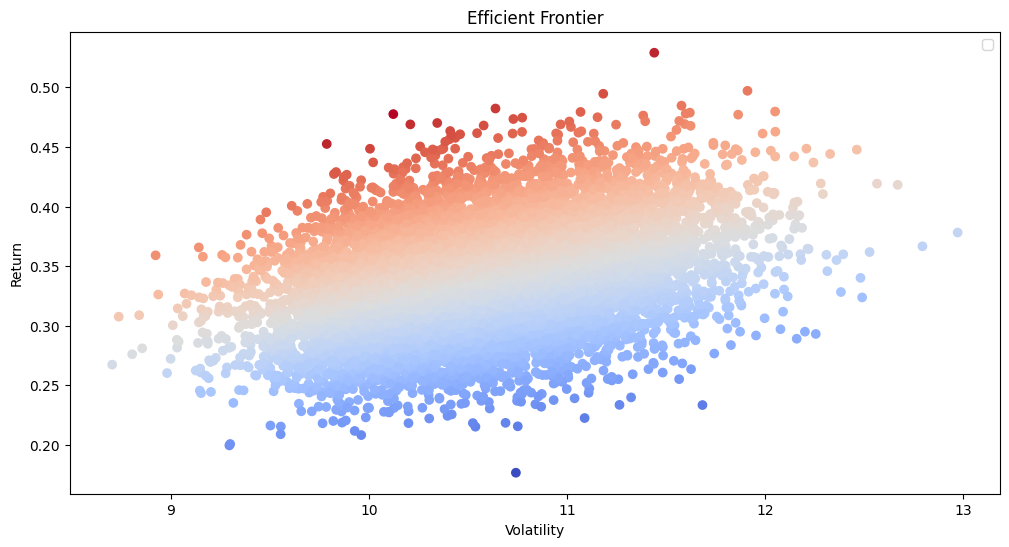

In [10]:

mean_returns = returns.mean()
num_portfolios = 10000
corr_matrix = data.corr()
results = np.zeros((3,num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
  
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(corr_matrix, weights))) * np.sqrt(252)
      
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = portfolio_return / portfolio_std_dev
  
results_df = pd.DataFrame(results.T,columns=['Return','Volatility','Sharpe'])

plt.figure(figsize=(12,6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='coolwarm')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.savefig("images/discount_ef.png")
plt.show()